<a href="https://colab.research.google.com/github/Namsik-Yoon/pytorch_basic/blob/master/6_2_Residual_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6_2 Residual Learning

이번 챕터에서는 2015년 ILSVRC[ILSVRC](https://bskyvision.com/425)에서 우승을 차지한 [ResNet](https://towardsdatascience.com/review-resnet-winner-of-ilsvrc-2015-image-classification-localization-detection-e39402bfa5d8)에 대해서 소개합니다.

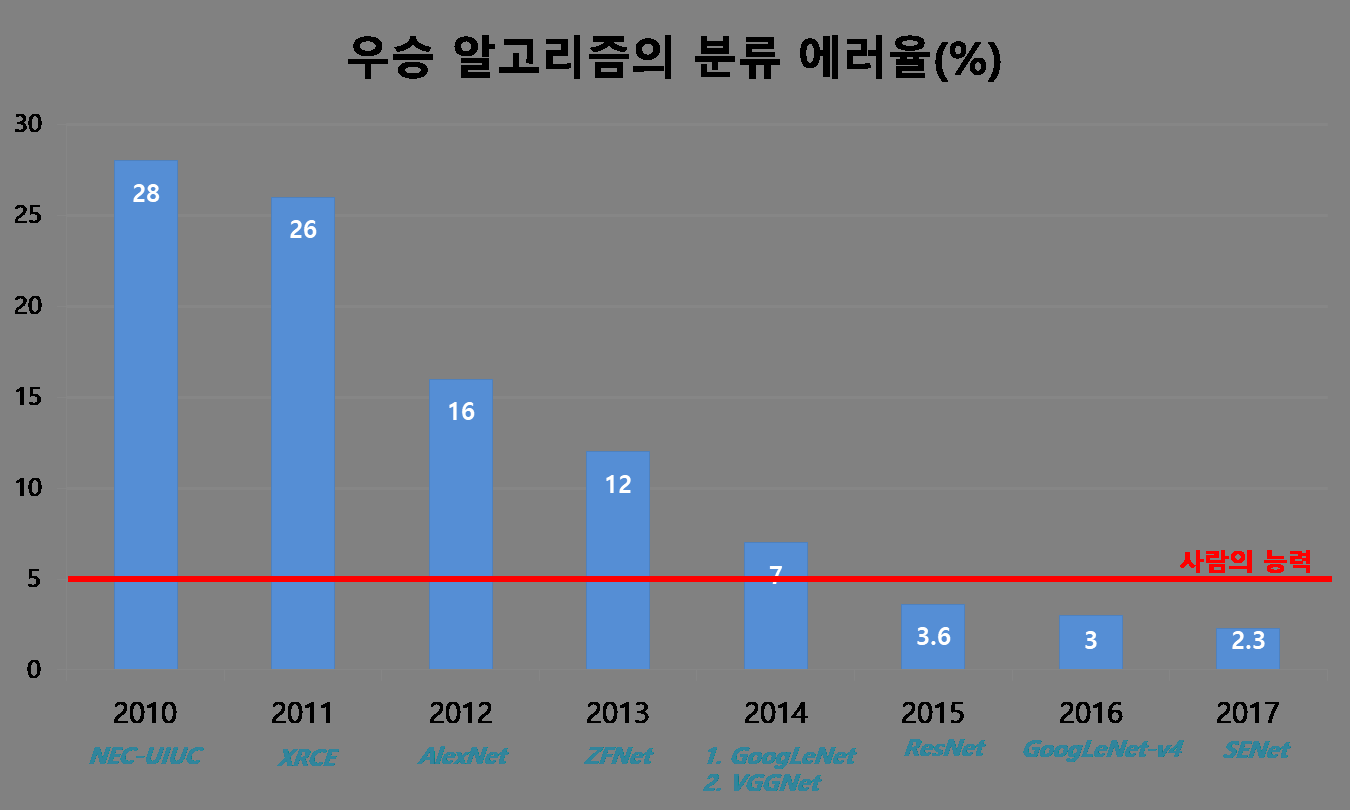

## 6_2.1 Introduction

ResNet은 15년도 전에 소개된 VGGNet, GoogLeNet과 같은 모델들 보다 훨씬 깊고 학습시키기도 더 쉬운 모델이라고 소개하고 있습니다. 이전의 연구들로 모델의 layer가 너무 깊어질 수록 오히려 성능이 떨어지는 현상이 생김을 밝혀냈습니다(한번 직접 실험해보세요). 

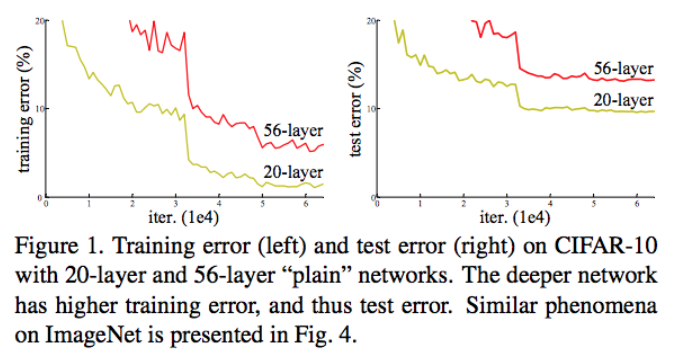

위의 그림은 20 레이어 CNN vs 56 레이어 CNN의 학습 및 테스트 에러의 그래프입니다. 이 그래프에 의해 더 많은 계층의 네트워크는 더 많은 기능을 가질 수 있지만 에러가 크게 나타남으로써 오버피팅에 의한 실패가 생길 수 있다는 것을 알 수 있습니다. 또한 더 깊은 네트워크가 수렴하기 시작하면 성능 저하 문제가 발생합니다. 네트워크 깊이가 증가하면 포화도가 포화된 다음 빠르게 저하됩니다. 훈련 정확도의 악화는 모든 시스템이 최적화하기 쉽지 않다는 것을 보여줍니다. 이는 gradient vanishing/exploding 문제 때문인것으로 밝혀졌습니다.

gradient vanashing이란 layer가 깊어질수록 미분을 점점 많이 하기 때문에 backpropagation을 해도 앞의 layer일수록 미분값이 작아져 그만큼 output에 영향을 끼치는 weight 정도가 작아지는 것을 말합니다. 이러한 현상을 degradation이라 하고 이는 overfitting과는 다른 문제인데 overfitting은 학습 데이터에 완벽하게 fitting시킨 탓에 테스트 성능에서는 안 좋은 결과를 보임을 뜻하고 위와 같은 문제는 Degradation 문제로 training data에도 학습이 되지 않음을 뜻합니다.

따라서 이를 극복하기 위해 ResNet이 고안되었으며 현재 SOTA를 이루고있는 모델들은 전부 ResNet의 Residual Learning기법을 사용하고있습니다. ResNet은 skip connenction을 이용한 residual learning을 통해 layer가 깊어짐에 따른 gradient vanishing문제를 해결하였습니다.

## 6_2.2 Gradient Vanishing 문제 확인

앞서 언급한 Gradient Vanishing문제가 어떻게 나타나는지 한번 실험해보겠습니다.

In [1]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [3]:
learning_rate = 0.0005
training_epochs = 50
batch_size = 256

In [4]:
cifar10_train = dsets.CIFAR10(root='cifar10/', # 다운로드 경로 지정
                          train=True, # True를 지정하면 훈련 데이터로 다운로드
                          transform=transforms.ToTensor(), # 텐서로 변환
                          download=True)

cifar10_test = dsets.CIFAR10(root='cifar10/', # 다운로드 경로 지정
                         train=False, # False를 지정하면 테스트 데이터로 다운로드
                         transform=transforms.ToTensor(), # 텐서로 변환
                         download=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
data_loader = torch.utils.data.DataLoader(dataset=cifar10_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [6]:
class SHALLOW_CNN(torch.nn.Module):
    def __init__(self):
        super(SHALLOW_CNN, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = torch.nn.Linear(8 * 8 * 64, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # 전결합층을 위해서 Flatten
        out = self.fc(out)
        return out

In [7]:
class CNN(torch.nn.Module):

    def __init__(self,num_layers):
        super(CNN, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))
        self.layers = []
        for _ in range(num_layers):
            self.layers.append(torch.nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1))
            self.layers.append(torch.nn.ReLU())
        self.layers = torch.nn.Sequential(*self.layers)
        
        self.fc = torch.nn.Linear(5 * 5 * 128, 10)
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layers(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc(out)
        return out

In [8]:
# CNN 모델 정의
shallow_model = CNN(4).to(device)
deep_model = CNN(12).to(device)

SHALLOW_CNN부터 학습시켜 보겠습니다.

In [9]:
criterion = torch.nn.CrossEntropyLoss().to(device)    # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(shallow_model.parameters(), lr=learning_rate)

In [10]:
total_batch = len(data_loader)
print('총 배치의 수 : {}'.format(total_batch))

총 배치의 수 : 195


In [11]:
shallow_costs = []
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y는 레이블.
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = shallow_model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch
    shallow_costs.append(avg_cost)
    if epoch%10==0:
        print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))   

[Epoch:    1] cost = 1.8618896
[Epoch:   11] cost = 0.603457808
[Epoch:   21] cost = 0.155494675
[Epoch:   31] cost = 0.0653235689
[Epoch:   41] cost = 0.0527405851


DEEP_CNN을 학습시켜 보겠습니다.

In [12]:
criterion = torch.nn.CrossEntropyLoss().to(device)    # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(deep_model.parameters(), lr=learning_rate)

In [13]:
deep_costs = []
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y는 레이블.
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = deep_model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch
    deep_costs.append(avg_cost)
    if epoch%10==0:
        print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))  

[Epoch:    1] cost = 2.30294466
[Epoch:   11] cost = 2.30262518
[Epoch:   21] cost = 2.30262327
[Epoch:   31] cost = 2.30262804
[Epoch:   41] cost = 2.30262399


2개의 cost를 비교해보겠습니다.

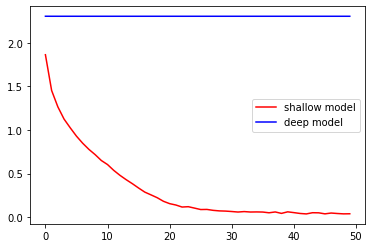

In [14]:
import matplotlib.pyplot as plt

plt.plot(shallow_costs, label = "shallow model",c='r')
plt.plot(deep_costs, label = "deep model",c='b')
plt.legend()
plt.show()

## 6_2.3 Residual Connection(Skip Connection)

기존의 neural net의 학습 목적은 input(x)을 target(y)으로 mapping하는 함수 H(x)를 찾는 것입니다. 따라서 loss(H(x), y)를 최소화하는 방향으로 학습을 진행합니다.

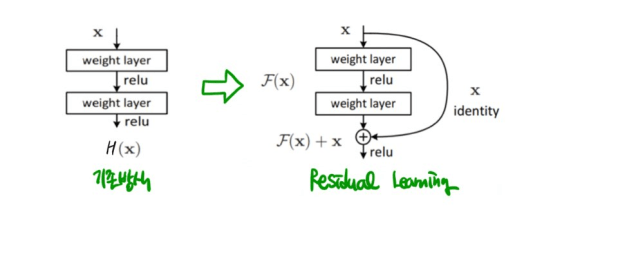

왼쪽은 "Plane" layer를 설명하는 그림이고, 오른쪽은 Residual Block을 설명하는 그림입니다.

두 구조의 차이점은 한 가지입니다. 동일한 연산을 하고 나서 input x를 더하는것(Residual Block)과 더하지 않는것(Plane layer)입니다.

단순하게 Input x 를 더하는 것만으로 레이어는 Direct로 학습하는 것 대신에, Skip Connection을 통해 각각의 Layer(Block)들이 작은 정보들을 추가적으로 학습하도록 합니다. (= 각각의 레이어가 배워야할 정보량을 축소)


**Plane Layer**

레이어의 아웃풋인 Feature vector를 y라고 할때, $y = f(x)$가 direct로 학습하는 위의 왼쪽 그림을 설명하는 수식이라고 할 수 있습니다. 여기에서 아웃풋인 y는 x를 통해 새롭게 학습하는 정보입니다. 즉, 기존에 학습한 정보를 보존하지 않고 변형시켜 새롭게 생성하는 정보입니다.

이 경우에 NN가 고차원적인 Feature vector로의 Mapping을 학습한다는 개념으로 생각했을 때, 층이 깊어질수록 한번에 학습해야할 Mapping이 너무 많아져 학습이 어려워 집니다.

**Residual Block**

반대로 오른쪽 그림을 설명하는 수식은 $y = f(x) + x$ 입니다. 여기에서의 y는 x가 그대로 보존되므로 기존에 학습한 정보를 보존하고, 거기에 추가적으로 학습하는 정보를 의미하게 됩니다. 즉, Output에 이전 레이어에서 학습했던 정보를 연결함으로써 해당 층에서는 추가적으로 학습해야할 정보만을 Mapping, 학습하게 됩니다.

예)
이해가 어렵다면 이렇게 생각해봅시다.

(1) 오픈북이 불가능한 시험
(2) 오픈북이 가능한 시험

문제가 쉬우면 오픈북 유무가 중요하지않지만, 문제가 어려워지면 어려워질수록 오픈북 유무가 중요합니다.

(1)의 경우에는 시험의 범위가 많아질수록(=층이 깊어지고 한번에 학습할 Mapping이 많은 경우) 공부하기가 어렵겠죠. 반면에 (2)의 경우에는 이미 배웠던 내용(x)가 제공되기 때문에 추가적으로 학습해야할 정보만을 공부할 것입니다.

## 6_2.4 Residual Connection with Bottle Neck Layer

또한 ResNet은 Deep Network에서의 연산량을 줄이기 위해 GoogLeNet에서 사용했던 Bottle Neck Layer를 사용한 Residual Block을 사용합니다.

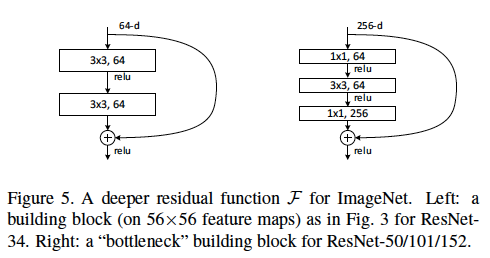

왼쪽은 Bottle Neck을 사용하지 않은 Residual Block이고 오픈쪽은 Bottle Neck을 사용한 Residual Block입니다.

(ResNet50 이상에서는 Bottle Neck을 사용한 Block을 사용했습니다)

오른쪽 그림을 확인하면 Input x의 Depth를 64로 축소한 후에 $f(x)$를 연산하고 마지막에 다시 256으로 높여주는것을 확인할 수 있습니다.

## 6_2.5 Simple Implenet ResNet

이번엔 간단히 ResNet을 구현하고 그 성능을 확인해보겠습니다.

In [15]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)
    
# Residual block
class ResidualBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class ResNet(torch.nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = torch.nn.BatchNorm2d(16)
        self.relu = torch.nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = torch.nn.AvgPool2d(8)
        self.fc = torch.nn.Linear(64, num_classes)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = torch.nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                torch.nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return torch.nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [16]:
model = ResNet(ResidualBlock, [2, 2, 2]).to(device)
# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
resnet_costs = []
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y는 레이블.
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch
    resnet_costs.append(avg_cost)
    if epoch%5==0:
        print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

[Epoch:    1] cost = 1.51392567
[Epoch:    6] cost = 0.662116289
[Epoch:   11] cost = 0.412747204
[Epoch:   16] cost = 0.239510342
[Epoch:   21] cost = 0.128326848
[Epoch:   26] cost = 0.0719182268
[Epoch:   31] cost = 0.0527280122
[Epoch:   36] cost = 0.0427176207
[Epoch:   41] cost = 0.0643350333
[Epoch:   46] cost = 0.0112683121
